In [1]:
import os

In [2]:
# check if in colab

using_colab = 'COLAB_RELEASE_TAG' in os.environ

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    os.chdir('/content/drive/MyDrive/HDA/HDA-lymphoma-classification')

    # pull changes
    ! git pull

    DATASET_DIR = '/content/drive/MyDrive/HDA/lymphoma'


else:
    DATASET_DIR = 'C:\\Users\\loren\\Datasets\\lymphoma'



In [3]:
from lymphoma_dataset import LymphomaDataset
import tensorflow as tf
from models import Inception_v4, ResNet50, CNN, EfficientNet
from evaluation import ModelEvaluation


In [4]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
## RUN PARAMETERS ##

SEED = 42

# DATASET PARAMETERS #

train_val_test_split = [0.6, 0.2, 0.2] # train, val, test split fractions
PATCH_SIZE = 256 # size of the patches
PATCH_STRIDE = PATCH_SIZE // 2 # if equal to PATCH_SIZE, no overlap
COLOR_SPACE = 'rgb' # 'rgb' or 'gray' or 'lab' or 'hed'
BATCH_SIZE = 32 # number of patches per batch

# MODEL PARAMETERS #

INPUT_CHANNELS = 1 if COLOR_SPACE == 'gray' else 3

# Dataset

In [6]:
preprocess_fn_kwargs = {'patch_sizes': [1, PATCH_SIZE, PATCH_SIZE, 1], 'patch_strides': [1, PATCH_STRIDE, PATCH_STRIDE, 1],
                        'patch_rates': [1, 1, 1, 1], 'patch_padding': 'VALID',
                        'color_space': COLOR_SPACE}

dataset_kwargs = {'batch_size': BATCH_SIZE,
                  'cache_file': None, # 'cache_' + COLOR_SPACE + '_' + str(PATCH_SIZE), # if 'memory', the dataset will be cached in memory (risk of OOM)
                  'shuffle': False, # whether to shuffle the dataset, set it to false to get predictions for each image
                  'buffer_size': 10*BATCH_SIZE,
                  'num_parallel_calls': 2, # enough to saturate the GPU compute capabilities
                  'extract_patches': True, # if False, the dataset will return the whole image
                  'reshape_patches': True} # if False returns a 5D tensor (batch, num_patches, patch_size, patch_size, channels) instead of a 4D tensor (batch*num_patches, patch_size, patch_size, channels)

data_augmentation = None

dataset = LymphomaDataset(dataset_path=DATASET_DIR, data_augmentation=data_augmentation,
                          preprocess_fn_kwargs=preprocess_fn_kwargs, dataset_kwargs=dataset_kwargs,
                          train_val_test_split=train_val_test_split, seed=SEED)



# Model evaluation

In [7]:
# load model weights
# model = Inception_v4(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS))
model = CNN(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS), filters=(64,128,256,512), compression_depth=4)
model.load_weights('./cnn/cnn')
model.summary()

Model: "custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv_l0 (Conv2D)            (None, 128, 128, 64)      3136      
                                                                 
 bn_l0 (BatchNormalization)  (None, 128, 128, 64)      256       
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv_l1 (Conv2D)            (None, 64, 64, 128)       131200    
                                                                 
 bn_l1 (BatchNormalization)  (None, 64, 64, 128)       512       
                                                                 
 activation_1 (Activation)   (None, 64, 64, 128)       0

In [8]:
import pickle

In [9]:
evaluator = ModelEvaluation(dataset=dataset, model=model, classifier_type='svm', seed=SEED, classifier_params=pickle.load(open('svm_params/cnn_best_params.pkl', 'rb')))

In [ ]:
evaluator.test_feature_extractor()

In [10]:
evaluator.extract_features(output_index=-2)

148/148 [==============================] - 4s 25ms/step


In [11]:
evaluator.train_classifier(optimize_params=False)

Train accuracy: 100.00%
Val accuracy: 92.00%
Test accuracy: 93.33%
Train precision: 100.00% Train recall: 100.00% Train f1-score: 100.00%
Val precision: 91.67% Val recall: 91.27% Val f1-score: 91.39%
Test precision: 93.33% Test recall: 93.59% Test f1-score: 93.29%
Train ROC AUC: 100.00%
Val ROC AUC: 98.06%
Test ROC AUC: 97.45%


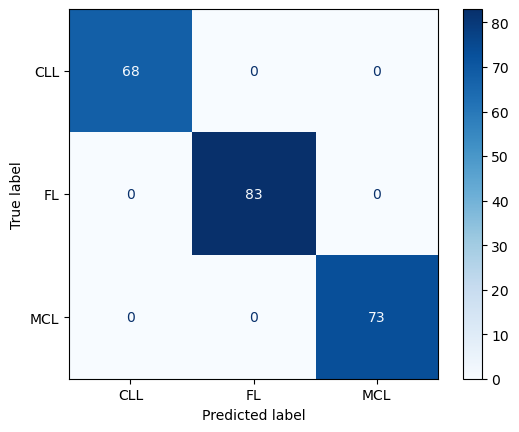

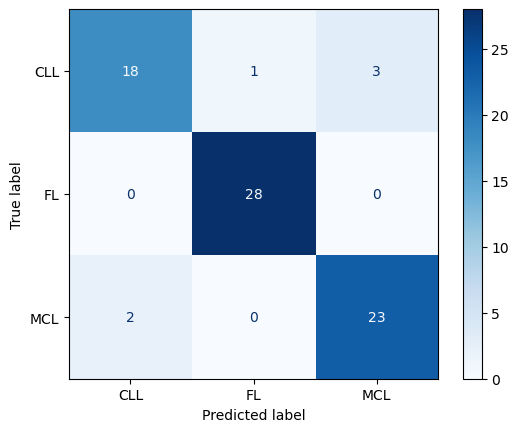

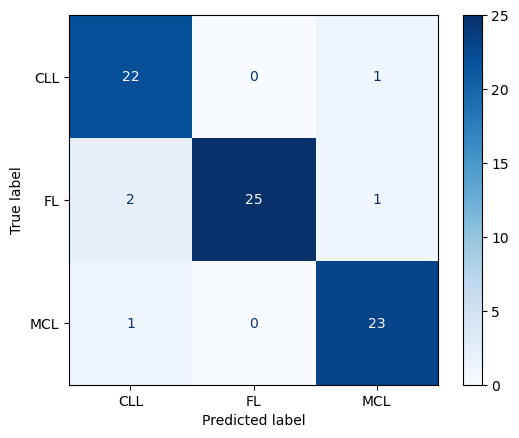

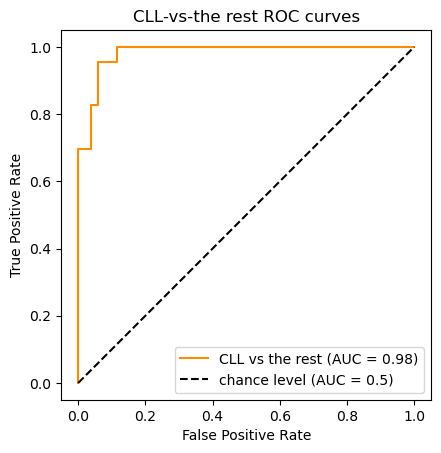

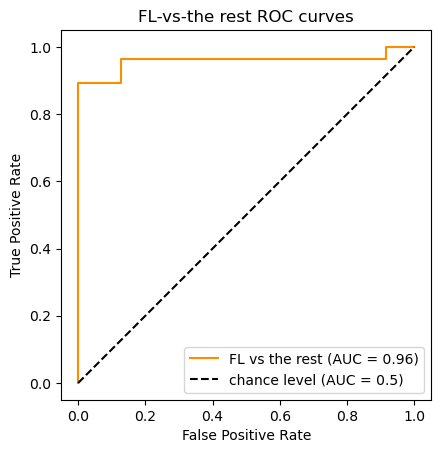

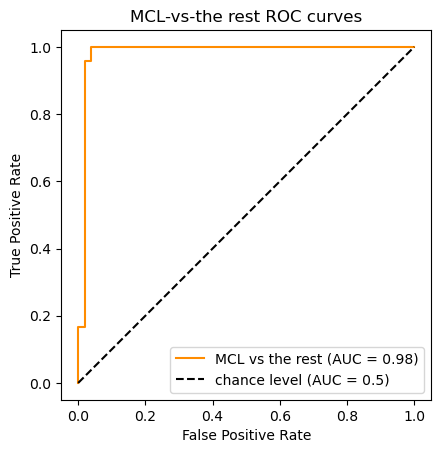

In [12]:
evaluator.test_classifier()